In [1]:
import scanpy as sc
import scvi
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

Global seed set to 0


In [2]:
tox_adata = sc.read_h5ad("/project/gilad/jpopp/cellcipher/data/Tox6-full/single_cell_objects/filtered_pflog1ppfnorm.hvg.umap_embedding.h5ad")
tox_adata_raw = sc.read_h5ad("/project/gilad/jpopp/cellcipher/data/Tox6-full/single_cell_objects/filtered.h5ad")

In [3]:
assert tox_adata.obs.index.equals(tox_adata_raw.obs.index)

In [7]:
sc.tl.leiden(tox_adata, resolution=1.25, key_added='leiden')

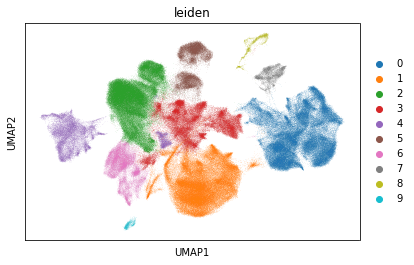

In [4]:
sc.pl.umap(tox_adata, color='leiden')

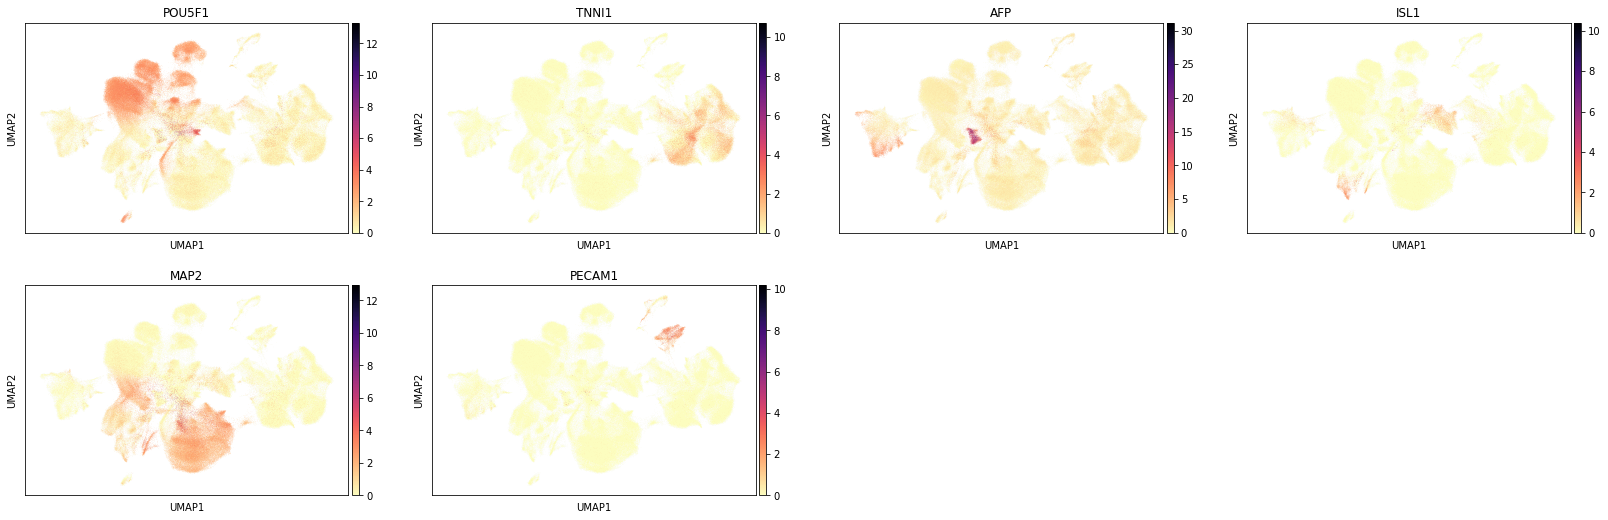

In [12]:
sc.pl.umap(tox_adata, color=['POU5F1', 'TNNI1', 'AFP', 'ISL1', 'MAP2', 'PECAM1'], color_map='magma_r')

In [13]:
celltype_labels = {0: 'mesoderm', 
                   1:'neuron', 
                   2: 'pluripotent', 
                   3: 'earlyecto', 
                   4: 'endoderm', 
                   5: 'pluripotent',
                  6: 'earlyecto',
                  7: 'endothelial',
                  8: 'endothelial',
                  9: 'pluripotent'}

In [14]:
tox_adata.obs['celltype'] = [celltype_labels[int(c)] for c in tox_adata.obs['leiden']]

In [15]:
tox_adata.obs[['treatment']].value_counts()

treatment
12           28206
11           27025
13           26094
14           25725
4            24587
16           24435
2            24235
1            23311
8            23167
6            23021
3            22991
10           22918
7            22875
15           22462
5            22378
9            22333
dtype: int64

In [16]:
treatment_map = {
    '1': 'Prenylamine',
    '2': 'Prenylamine',
    '3': 'Droxicam',
    '4': 'Droxicam',
    '5': 'Chlorpheniramine',
    '6': 'Chlorpheniramine',
    '7': 'Amoxycillin',
    '8': 'Amoxycillin',
    '9': 'Simvastatin',
    '10': 'Simvastatin', 
    '11': 'Gemifloxacin',
    '12': 'Gemifloxacin',
    '13': 'Diamthazole',
    '14': 'Diamthazole', 
    '15': 'Propranolol',
    '16': 'Propranolol'
}

In [17]:
tox_adata.obs['treatment_name'] = [treatment_map[t] for t in tox_adata.obs['treatment']]

In [18]:
cell_subset = tox_adata.obs[['sample_id', 'donor_id', 'celltype']]
cell_subset['pseudobulk_sample'] = cell_subset['sample_id'].astype(str) + '_' + cell_subset['donor_id'].astype(str) + '_' + cell_subset['celltype'].astype(str)

/tmp/jobs/31491592/ipykernel_121346/782936707.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_subset['pseudobulk_sample'] = cell_subset['sample_id'].astype(str) + '_' + cell_subset['donor_id'].astype(str) + '_' + cell_subset['celltype'].astype(str)


In [19]:
onehot = OneHotEncoder(sparse=True).fit_transform(cell_subset[['pseudobulk_sample']])
onehot

<385763x432 sparse matrix of type '<class 'numpy.float64'>'
	with 385763 stored elements in Compressed Sparse Row format>

In [20]:
pseudobulk_sum = tox_adata_raw.X.transpose() * onehot

In [21]:
pseudobulk_sum = pd.DataFrame(pseudobulk_sum.todense(),
                              index=tox_adata_raw.var_names, 
                              columns=cell_subset['pseudobulk_sample'].astype("category").cat.categories).astype(int)

In [22]:
pseudobulk_sum.to_csv("/project/gilad/jpopp/cellcipher/data/Tox6-full/pseudobulk_expression.tsv", sep="\t")

In [23]:
treatment_dict = tox_adata.obs[['sample_id', 'treatment', 'treatment_name']].drop_duplicates()

In [24]:
treatment_dict

,sample_id,treatment,treatment_name
cell,,,
AAACCCAAGACTCCGC-1,YG-KR-16S-1002-Tox6-03-3,3,Droxicam
AAACCCAAGAACTGAT-2,YG-KR-16S-1002-Tox6-06-6,6,Chlorpheniramine
AAACCCAAGAATTGCA-3,YG-KR-16S-1002-Tox6-10-10,10,Simvastatin
AAACCCAAGGAATTAC-4,YG-KR-16S-1002-Tox6-05-5,5,Chlorpheniramine
AAACCCAAGAAACCCG-5,YG-KR-16S-1002-Tox6-04-4,4,Droxicam
AAACCCAAGAGGATCC-6,YG-KR-16S-1002-Tox6-11-11,11,Gemifloxacin
AAACCCAAGAAGCCTG-7,YG-KR-16S-1002-Tox6-08-8,8,Amoxycillin
AAACCCAAGACGAGCT-8,YG-KR-16S-1002-Tox6-09-9,9,Simvastatin
AAACCCAAGGCATGCA-9,YG-KR-16S-1002-Tox6-15-15,15,Propranolol


In [25]:
treatment_dict.to_csv("/project/gilad/jpopp/cellcipher/data/Tox6-full/treatment_dict.tsv", sep="\t", index=False)